<a href="https://colab.research.google.com/github/ayachiii/soturon/blob/main/focus_on_single_subject%E8%87%AA%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

一被験者のデータを深掘り。
認知作業負荷とLFのグラフから、フローになったかどうかを可視化するグラフの作成。

In [ ]:
lf_values = [1, 2, 3, 4, 5]

# リストを DataFrame に変換して 'lf' カラムを持たせる
df = pd.DataFrame(lf_values, columns=['lf'])

In [ ]:
!pip install heartpy

In [ ]:
import heartpy as hp
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import re

対象: tenshin / ultra

--- PLIデータの処理 ---


<Figure size 1000x500 with 0 Axes>

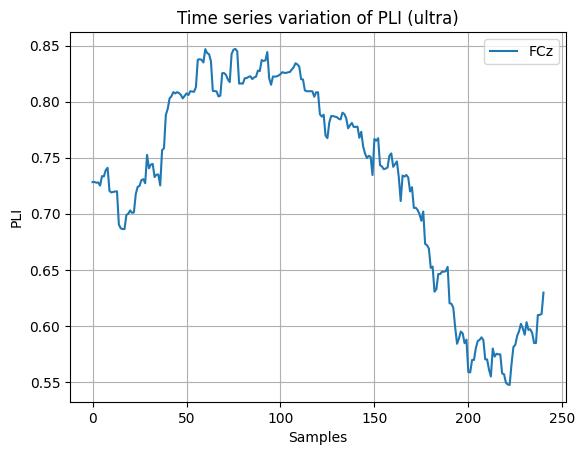

PLIのプロットが完了しました。

--- ECGデータの処理とLF時系列解析 ---
tenshin さんの ultra フェーズのデータを分析します。
計測時間は196.526秒です
LFの時系列計算を開始します（時間がかかる場合があります）...


/usr/local/lib/python3.12/dist-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)


計算データ点数: 77
           lf
0  290.844601
1  286.450900
2  287.601595
3  285.494072
4  283.228525


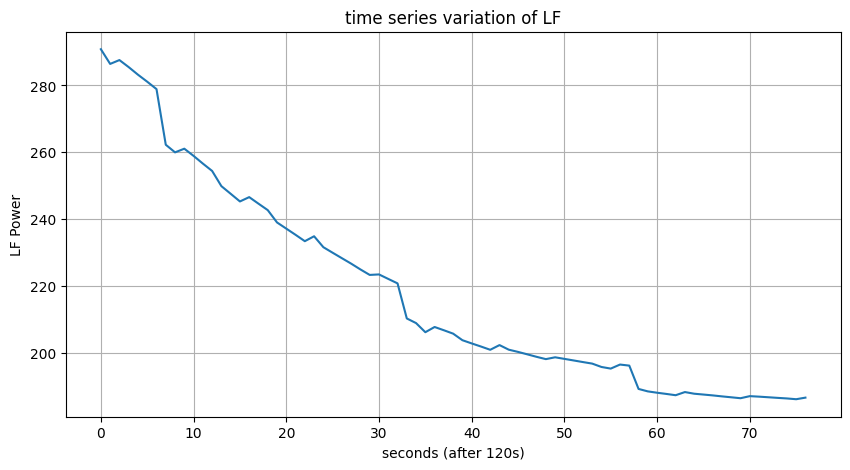

In [20]:
# 手動⇩
PLI_FILE_NAME = "PLI_4_tenshin_ultra.csv"
ECG_FILE_NAME = "ECG_tenshin_ultra.csv"
SUBJECT_NAME = "tenshin"
PHASE_NAME = "ultra"
SAMPLING_RATE = 500.0  # Constants.fs の代わり
#ここまで手動入力


print(f"対象: {SUBJECT_NAME} / {PHASE_NAME}")

# ==========================================
# パート1: PLIデータの時系列プロット
# ==========================================
print("\n--- PLIデータの処理 ---")

try:
    # PLIデータを読み込み
    pli_df = pd.read_csv(PLI_FILE_NAME)

    # FCz列が存在するか確認
    if "FCz" in pli_df.columns:
        pli_df = pli_df[["FCz"]]

        # プロット
        plt.figure(figsize=(10, 5))
        pli_df.plot()
        plt.title(f"Time series variation of PLI ({PHASE_NAME})")
        plt.xlabel("Samples") # 元コードではsecondsとなっていましたが、indexでプロットされるためSamples表記が正確です
        plt.ylabel("PLI")
        plt.legend()
        plt.grid(True)
        plt.show()
        print("PLIのプロットが完了しました。")
    else:
        print("エラー: PLIファイル内に 'FCz' カラムが見つかりません。")

except FileNotFoundError:
    print(f"エラー: {PLI_FILE_NAME} が見つかりません。アップロードしてください。")
except Exception as e:
    print(f"PLI処理中にエラーが発生しました: {e}")


# ==========================================
# パート2: ECGデータからのLF時系列解析
# ==========================================
print("\n--- ECGデータの処理とLF時系列解析 ---")

try:
    # ECGデータを読み込み
    # hp.get_data は列名を指定してデータを取得します
    hrdata = hp.get_data(ECG_FILE_NAME, delim=",", column_name="ECG")

    # 特例措置（kimさんの場合）のロジックは残しておきます
    if SUBJECT_NAME == "kim":
        hrdata = hrdata * (-1)

    print(f"{SUBJECT_NAME} さんの {PHASE_NAME} フェーズのデータを分析します。")
    sec = len(hrdata) / SAMPLING_RATE
    print(f"計測時間は{sec}秒です")

    # --- LF時系列の計算ループ ---

    # 初期設定
    current_time = int(120 * SAMPLING_RATE) # 120秒から開始
    slice_value_s = 1 # 1秒ずつ増やす
    lf_time_series = []

    print("LFの時系列計算を開始します（時間がかかる場合があります）...")

    # データが終わるまでループ
    while current_time < len(hrdata):

        # 元コードのロジック: 0秒から current_time までの「拡大していく窓」で解析
        hrdata_slice = hrdata[0: current_time]

        try:
            # HeartPyで解析 (calc_freq=Trueで周波数解析を有効化)
            working_data, measures = hp.process(
                hrdata_slice,
                SAMPLING_RATE,
                report_time=False,
                calc_freq=True
            )

            # LFを取得してリストに追加
            lf = measures["lf"]
            lf_time_series.append(lf)

        except Exception as e:
            # ノイズ等で解析エラーが出た場合はNaNを入れておく（またはスキップ）
            # print(f"Time {current_time/SAMPLING_RATE}s: 解析エラー (スキップします)")
            lf_time_series.append(np.nan)

        # 時間を進める
        current_time += int(slice_value_s * SAMPLING_RATE)

    # --- 結果の処理とプロット ---

    # DataFrameに変換
    df_lf = pd.DataFrame(lf_time_series, columns=['lf'])

    # エラーでNaNが入った行があれば削除
    df_lf = df_lf.dropna()

    print(f"計算データ点数: {len(df_lf)}")
    print(df_lf.head())

    # 平均と標準偏差を計算
    mean = df_lf['lf'].mean()
    std_dev = df_lf['lf'].std()

    # 3シグマ法で外れ値を平均値に置き換え
    df_lf['lf'] = np.where(
        (df_lf['lf'] < mean - 3 * std_dev) | (df_lf['lf'] > mean + 3 * std_dev),
        mean,
        df_lf['lf']
    )

    # プロット
    plt.figure(figsize=(10, 5))
    plt.plot(df_lf['lf'])
    plt.title("time series variation of LF")
    plt.xlabel("seconds (after 120s)") # ループ回数が秒数に対応
    plt.ylabel("LF Power") # 縦軸ラベル修正 (元のコードではPLIになっていましたがLFが正しいです)
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"エラー: {ECG_FILE_NAME} が見つかりません。アップロードしてください。")
except Exception as e:
    print(f"ECG処理中にエラーが発生しました: {e}")

/tmp/ipython-input-3719866622.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_60_shift = pd.concat([zeros_df, df], ignore_index=True)


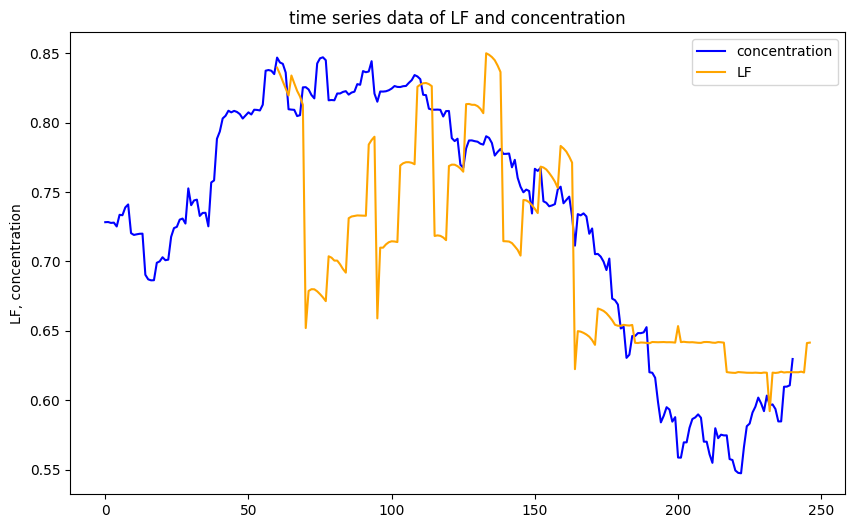

In [21]:
zeros_df = pd.DataFrame({'lf': [None] * 60})

df_60_shift = pd.concat([zeros_df, df], ignore_index=True)

# グラフの作成
plt.figure(figsize=(10, 6))

# pli_dfのプロット
plt.plot(pli_df['FCz'], label='concentration', color='blue')

# dfのプロット
plt.plot(df_60_shift['lf']/df["lf"].max() - 0.15, label='LF', color='orange')

# グラフの装飾
plt.xlabel('')  # x軸ラベル
plt.ylabel('LF, concentration')  # y軸ラベル
plt.title('time series data of LF and concentration')  # タイトル
plt.legend()  # 凡例を表示

# グラフを表示
plt.show()

In [22]:
print(df)
print(len(lf_time_series))
print(max(lf_time_series))
lf_time_series.remove(max(lf_time_series))
print(max(lf_time_series))
lf_time_series.remove(max(lf_time_series))
lf_time_series.remove(max(lf_time_series))

lf_time_series.remove(max(lf_time_series))
print(max(lf_time_series))





             lf
0    518.065569
1    515.624315
2    512.868786
3    510.255372
4    507.562662
..          ...
182  403.147641
183  403.372034
184  403.048501
185  414.167767
186  414.332982

[187 rows x 1 columns]
77
290.8446011118147
287.60159545342617
283.22852538967595


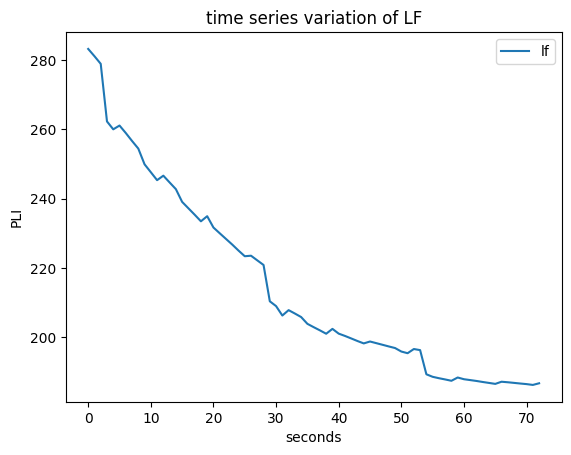

In [23]:
df = pd.DataFrame(lf_time_series, columns=['lf'])


df.plot()
plt.title("time series variation of LF")
plt.xlabel("seconds")
plt.ylabel("PLI")
plt.show()